In [1]:
import pandas as pd 
import numpy as np 
import talib as tb
import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
df_eth = pd.read_csv(r'../data/cryptocsv/eth.csv')

# Creating Indicators

In [3]:
df_sp500 = yf.download('^GSPC', 
                      start='2017-11-09', 
                      end='2022-04-26', 
                      progress=False,
)

df_dollar = yf.download('DX=F', 
                      start='2017-11-09', 
                      end='2022-04-26', 
                      progress=False,
)
df_dollar.head(10)


1 Failed download:
- ^GSPC: No data found for this date range, symbol may be delisted

1 Failed download:
- DX=F: No data found for this date range, symbol may be delisted


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [4]:
df_dollar.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_dollar.rename(columns={"Close": "dollar_close"}, inplace=True)
df_sp500.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_sp500.rename(columns={"Close": "sp500_close"}, inplace=True)


In [5]:
df_eth[~(df_eth['adj_close'].isna())].head(10)

,Unnamed: 0,Date,adj_close,close,low,high,open,volume
197,197,2017-11-09,320.884003,320.884003,307.056000,329.451996,308.644989,8.932500e+08
198,198,2017-11-10,299.252991,299.252991,294.541992,324.717987,320.670990,8.859860e+08
199,199,2017-11-11,314.681000,314.681000,298.191986,319.453003,298.585999,8.423010e+08
200,200,2017-11-12,307.907990,307.907990,298.513000,319.153015,314.690002,1.613480e+09
201,201,2017-11-13,316.716003,316.716003,307.024994,328.415009,307.024994,1.041890e+09
202,202,2017-11-14,337.631012,337.631012,316.763000,340.177002,316.763000,1.069680e+09
203,203,2017-11-15,333.356995,333.356995,329.812988,340.911987,337.963989,7.226660e+08
204,204,2017-11-16,330.924011,330.924011,323.605988,336.158997,333.442993,7.972540e+08
205,205,2017-11-17,332.394012,332.394012,327.523010,334.963989,330.166992,6.217330e+08
206,206,2017-11-18,347.612000,347.612000,327.687012,349.615997,331.980011,6.496390e+08


In [6]:
df_eth.drop('Unnamed: 0', axis=1, inplace=True)
df_eth.drop('adj_close', axis=1, inplace=True)
df_eth.set_index('Date', inplace=True)
df_eth.index = df_eth.index.astype('datetime64[ns]')
df_eth.dropna(inplace=True)

In [7]:
df_eth

,close,low,high,open,volume
Date,,,,,
2017-11-09,320.884003,307.056000,329.451996,308.644989,8.932500e+08
2017-11-10,299.252991,294.541992,324.717987,320.670990,8.859860e+08
2017-11-11,314.681000,298.191986,319.453003,298.585999,8.423010e+08
2017-11-12,307.907990,298.513000,319.153015,314.690002,1.613480e+09
2017-11-13,316.716003,307.024994,328.415009,307.024994,1.041890e+09
...,...,...,...,...,...
2022-04-21,2987.480713,2962.410400,3173.451416,3077.829346,2.078359e+10
2022-04-22,2964.835693,2942.358643,3024.854492,2986.938721,1.678280e+10
2022-04-23,2938.114014,2926.740234,2975.322754,2964.802246,9.116956e+09


## Moving Average

In [8]:
eth_ma = df_eth['close'].to_frame()
eth_ma['SMA30'] = eth_ma['close'].rolling(30).mean()
eth_ma['CMA30'] = eth_ma['close'].expanding().mean()
eth_ma['EMA30'] = tb.EMA(df_eth['close'], timeperiod=30)
eth_ma.dropna(inplace=True)
eth_ma

,close,SMA30,CMA30,EMA30
Date,,,,
2017-12-08,456.031006,400.082003,400.082003,400.082003
2017-12-09,473.502014,405.169270,402.450390,404.818778
2017-12-10,441.721008,409.918204,403.677597,407.199567
2017-12-11,515.135986,416.600037,407.055124,414.163207
2017-12-12,651.431030,428.050805,414.242651,429.470808
...,...,...,...,...
2022-04-21,2987.480713,3199.351164,1063.847074,3095.944448
2022-04-22,2964.835693,3197.143449,1065.016194,3087.485819
2022-04-23,2938.114014,3191.478516,1066.167452,3077.848928


In [9]:
fig = px.line(eth_ma, x=eth_ma.index, y =['close', 'SMA30', 'CMA30', 'EMA30'],  color_discrete_sequence=px.colors.qualitative.G10)
fig

## Stochastic Oscillator

https://www.investopedia.com/terms/s/stochasticoscillator.asp

1. A stochastic oscillator is a popular technical indicator for generating overbought and oversold signals.
2. Buy/Sell when both K and D are below 20% or above 80%
3. Stochastic oscillators tend to vary around some mean price level, since they rely on an asset's price history.

In [10]:
slowk, slowd = tb.STOCH(df_eth["high"], df_eth["low"], df_eth["close"], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
eth_stoch = pd.DataFrame(index=df_eth.index,
                            data={"slowk": slowk,
                                  "slowd": slowd})

eth_stoch.dropna(inplace=True)


eth_stoch

,slowk,slowd
Date,,
2017-11-17,77.873856,80.783803
2017-11-18,81.735528,81.334123
2017-11-19,77.770765,79.126716
2017-11-20,82.435804,80.647365
2017-11-21,75.518558,78.575042
...,...,...
2022-04-21,64.679521,64.653946
2022-04-22,42.828174,61.069701
2022-04-23,21.151273,42.886322


In [11]:
def signal(k, d): 
    if (d <= 20 and k<=20) or (d >=80 and k>=80): 
        return 1
    else: return 0

In [12]:
eth_stoch['stoch_signal'] = eth_stoch.apply(lambda x: signal(x.slowk, x.slowd), axis=1)

In [13]:
fig = px.bar(eth_stoch, x=eth_stoch.index, y =['stoch_signal'],  color_discrete_sequence=px.colors.qualitative.G10)
fig

In [14]:
# for later use in the concat
stoch_c = ['slowk', 'slowd']

## MACD - Moving Average Convergence/Divergence

https://www.investopedia.com/terms/m/macd.asp

1. MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
2. The speed of crossovers is also taken as a signal of a market is overbought or oversold.
3. MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.

In [15]:
macd, macdsignal, macdhist = tb.MACD(df_eth.close, fastperiod=12, slowperiod=26, signalperiod=9)

In [16]:
eth_macd = pd.DataFrame(index=df_eth.index,
                            data={"macd": macd,
                                  "macdsignal": macdsignal,
                                  "macdhist": macdhist})

eth_macd.dropna(inplace=True)
eth_macd


,macd,macdsignal,macdhist
Date,,,
2017-12-12,53.550952,50.810936,2.740015
2017-12-13,66.384639,53.925677,12.458962
2017-12-14,75.128503,58.166242,16.962261
2017-12-15,80.216096,62.576213,17.639883
2017-12-16,84.226156,66.906201,17.319955
...,...,...,...
2022-04-21,-21.003927,5.781681,-26.785609
2022-04-22,-28.661926,-1.107040,-27.554886
2022-04-23,-36.466794,-8.178991,-28.287803


In [17]:
# for later use in the concat
macd_c = ['macd', 'macdsignal', 'macdhist']

## Bollinger Bands

In [18]:
upper, middle, lower = tb.BBANDS(df_eth["close"], timeperiod=30)
eth_bands = pd.DataFrame(index=df_eth.index,
                            data={"bb_low": lower,
                                  "bb_ma": middle,
                                  "bb_high": upper})
eth_bands.dropna(inplace=True)
eth_bands

,bb_low,bb_ma,bb_high
Date,,,
2017-12-08,272.823019,400.082003,527.340986
2017-12-09,278.781964,405.169270,531.556575
2017-12-10,289.228888,409.918204,530.607520
2017-12-11,295.546009,416.600037,537.654065
2017-12-12,286.958109,428.050805,569.143500
...,...,...,...
2022-04-21,2866.562736,3199.351164,3532.139591
2022-04-22,2859.081758,3197.143449,3535.205140
2022-04-23,2842.128490,3191.478516,3540.828542


In [19]:
# for later use in the concat
bands_c = ['bb_low', 'bb_ma', 'bb_high']

## Relative strength index (RSI)

https://www.investopedia.com/terms/r/rsi.asp

1. The RSI provides technical traders with signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset’s price.
2. An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

In [20]:
rsi = tb.RSI(df_eth['close'], timeperiod=30)

In [21]:
eth_rsi = pd.DataFrame(index=df_eth.index,
                            data={"close": df_eth['close'],
                                  "rsi": rsi})

eth_rsi.dropna(inplace=True)
eth_rsi.head(10)

,close,rsi
Date,,
2017-12-09,473.502014,67.039114
2017-12-10,441.721008,62.454273
2017-12-11,515.135986,67.728465
2017-12-12,651.431030,74.584993
2017-12-13,702.767029,76.528106
2017-12-14,695.815979,75.717230
2017-12-15,684.447998,74.383808
2017-12-16,696.208984,74.857681
2017-12-17,719.974976,75.793755


In [22]:
fig = px.line(eth_rsi, x=eth_rsi.index, y =['close', 'rsi'],  color_discrete_sequence=px.colors.qualitative.G10)
fig

## Fibonacci retracement

## Ichimoku cloud

## Standard deviation

In [23]:
stdev = tb.STDDEV(df_eth['close'], timeperiod=30, nbdev=1)

In [24]:
eth_stdev = pd.DataFrame(index=df_eth.index,
                            data={"close": df_eth['close'],
                                  "stdev": stdev})

eth_stdev.dropna(inplace=True)
eth_stdev


,close,stdev
Date,,
2017-12-08,456.031006,63.629492
2017-12-09,473.502014,63.193653
2017-12-10,441.721008,60.344658
2017-12-11,515.135986,60.527014
2017-12-12,651.431030,70.546348
...,...,...
2022-04-21,2987.480713,166.394214
2022-04-22,2964.835693,169.030846
2022-04-23,2938.114014,174.675013


## Average directional index

https://www.investopedia.com/terms/a/adx.asp#:~:text=The%20average%20directional%20index%20(ADX)%20is%20a%20technical%20analysis%20indicator,positive%20directional%20indicator%20(%2BDI).

1. The ADX makes use of a positive (+DI) and negative (-DI) directional indicator in addition to the trendline.
2. The trend has strength when ADX is above 25; the trend is weak or the price is trendless when ADX is below 20, according to Wilder.
3. Non-trending doesn't mean the price isn't moving. It may not be, but the price could also be making a trend change or is too volatile for a clear direction to be present.

In [25]:
adx = tb.ADX(df_eth['high'], df_eth['low'], df_eth['close'], timeperiod=20)

In [26]:
eth_adx = pd.DataFrame(index=df_eth.index,
                            data={"close": df_eth['close'],
                                  "adx": adx})

eth_adx.dropna(inplace=True)
eth_adx

,close,adx
Date,,
2017-12-18,794.645020,37.573268
2017-12-19,826.822998,38.843567
2017-12-20,819.085999,39.647736
2017-12-21,821.062988,40.545057
2017-12-22,674.859985,39.001209
...,...,...
2022-04-21,2987.480713,13.298290
2022-04-22,2964.835693,13.319277
2022-04-23,2938.114014,13.400342


## Creating full dataframe 

First, know the most recent time table present

In [27]:
df_dollar['dollar_close']

Series([], Name: dollar_close, dtype: float64)

In [28]:
result =pd.concat([df_eth, eth_ma[['SMA30','CMA30','EMA30']], eth_adx['adx'], eth_bands[bands_c], eth_macd[macd_c], eth_rsi['rsi'], eth_stdev['stdev'], eth_stoch[stoch_c], df_dollar['dollar_close'], df_sp500['sp500_close']], axis=1)

In [29]:
result.dropna(inplace=True)

In [30]:
result

,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,bb_low,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,


# Correlation Matrix

In [202]:
result = pd.read_csv(r'../data/cryptoInd/eth_ind.csv', index_col='Date')

## Scaling

ASK TEACHER: should i do this?

In [126]:
scaled_df = result.copy()
scaler_std = StandardScaler()
scaled_feat = scaler_std.fit_transform(result)
scaled_df = pd.DataFrame(scaled_feat, index = result.index, columns=result.columns)
scaled_df.head()

,adj_close,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-12,-0.341479,-0.341479,-0.439232,-0.354764,-0.443179,-0.703342,-0.479313,-0.546662,-0.475964,0.654631,...,-0.457800,0.493272,0.488323,0.108479,1.905817,-0.244128,0.839447,0.454673,-0.273601,-1.020815
2017-12-13,-0.300906,-0.300906,-0.362584,-0.285521,-0.346362,-0.759625,-0.467081,-0.506423,-0.453414,0.834458,...,-0.410960,0.646172,0.527752,0.481387,2.096824,0.021482,1.577599,1.012913,-0.494745,-1.022653
2017-12-14,-0.306399,-0.306399,-0.307388,-0.281605,-0.302392,-0.820002,-0.452804,-0.469362,-0.434377,1.005256,...,-0.378763,0.750345,0.581432,0.654174,1.998605,0.165687,1.365336,1.354209,-0.474672,-1.038463
2017-12-15,-0.315384,-0.315384,-0.343474,-0.324361,-0.305722,-0.911292,-0.440175,-0.435805,-0.418857,1.056771,...,-0.355274,0.810958,0.637257,0.680174,1.834188,0.256422,1.107175,1.450618,-0.324119,-1.003751
2017-12-18,-0.228291,-0.228291,-0.287474,-0.242806,-0.285702,-0.869161,-0.396806,-0.325981,-0.367965,1.313725,...,-0.278853,1.004357,0.810204,0.778813,2.256231,0.536729,1.166785,1.108845,-0.460955,-0.982823


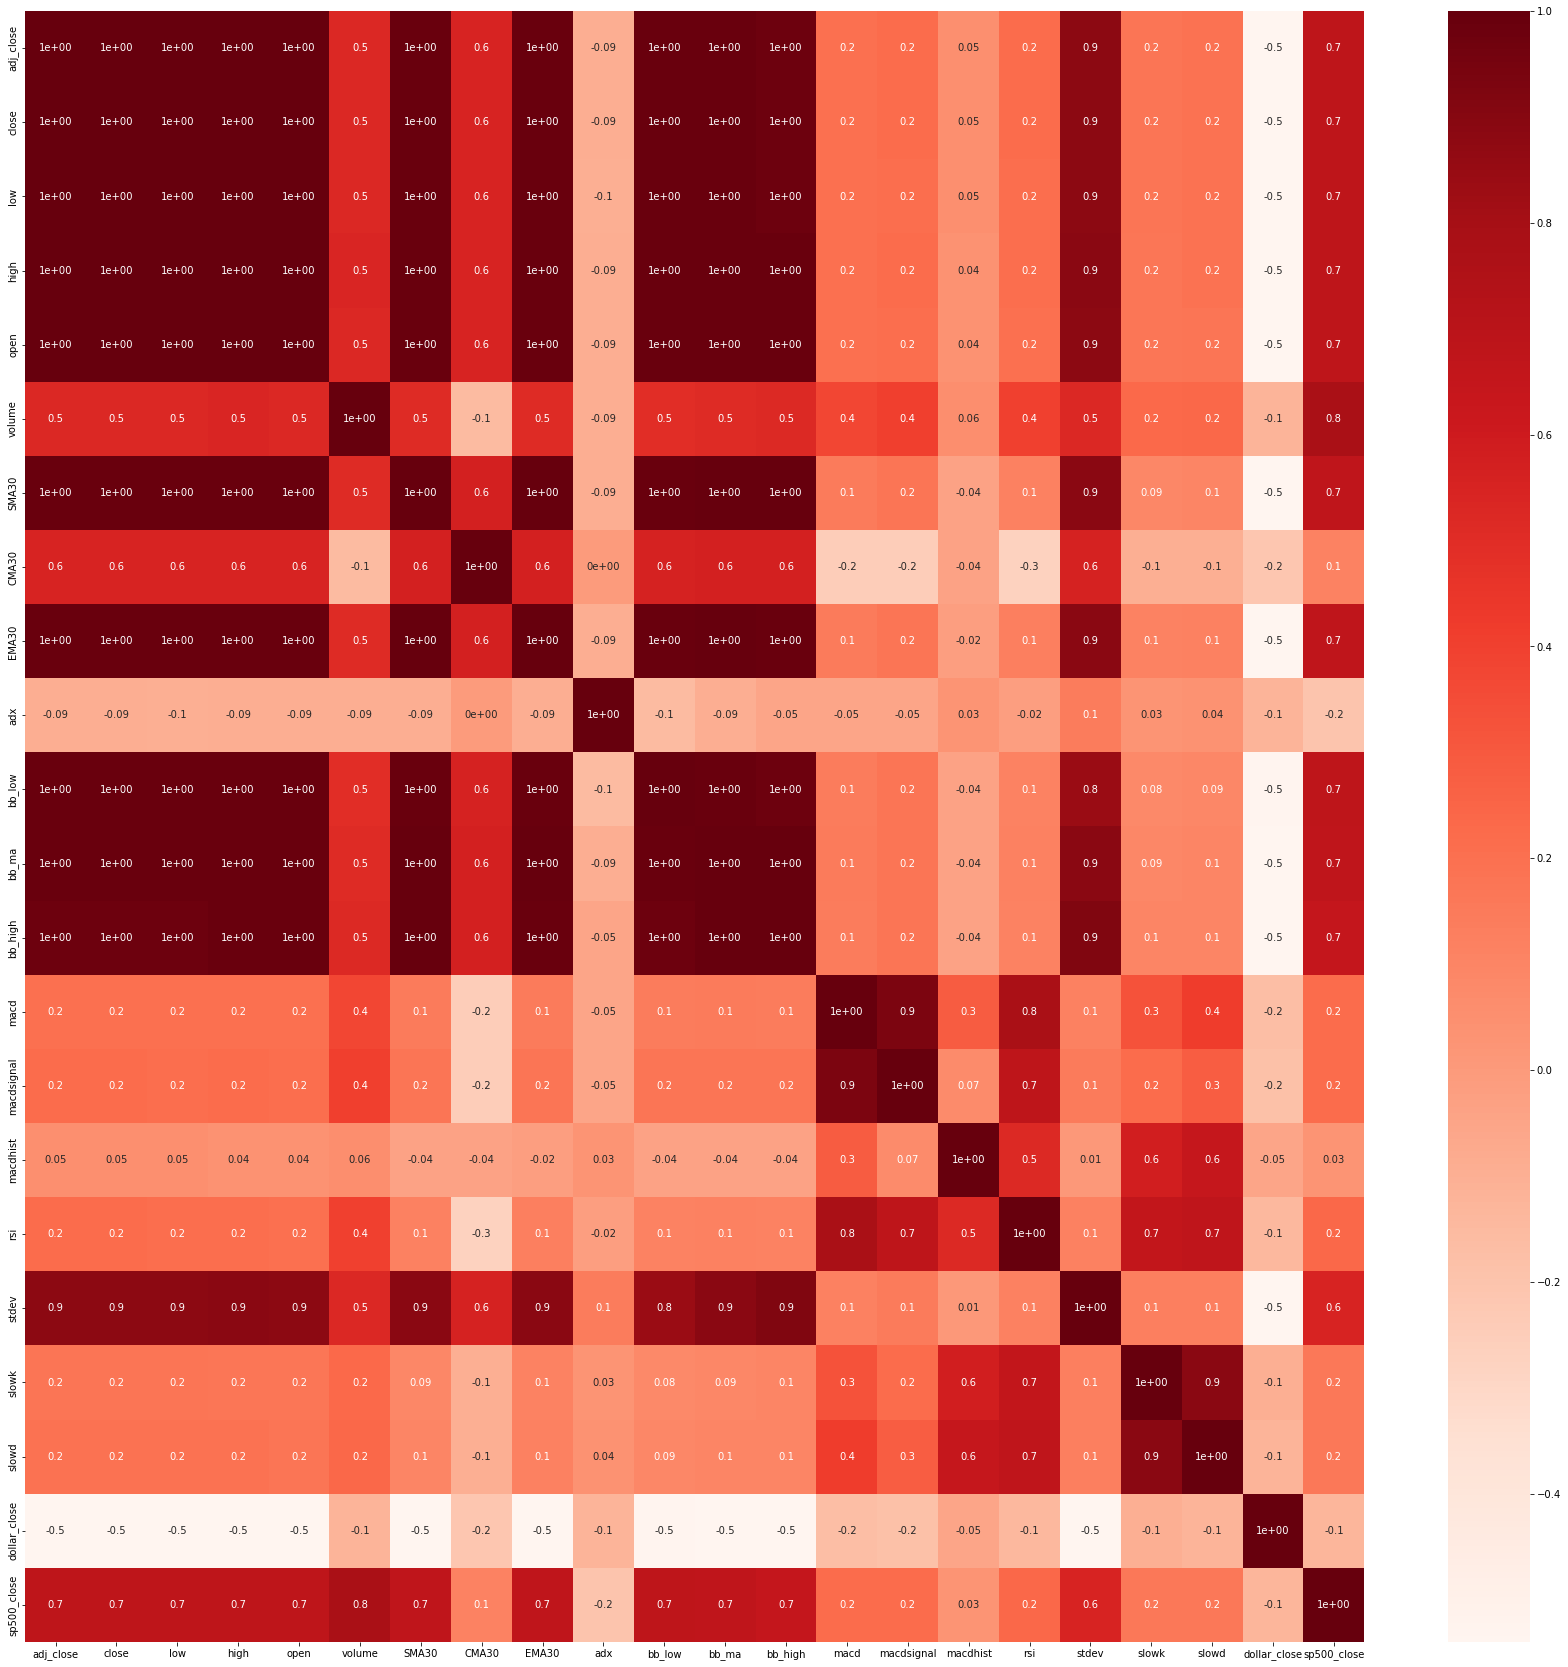

In [127]:
# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

As we can see high, low, open, SMA30, EMA30 and the Bollinger Bands pretty much all tell the same information and are highly correlated. These variables will then be removed. 

In [128]:
scaled_df.columns

Index(['adj_close', 'close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30',
       'EMA30', 'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal',
       'macdhist', 'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close',
       'sp500_close'],
      dtype='object')

In [129]:
scaled_df.drop(['low', 'open','SMA30', 'EMA30','bb_low', 'bb_ma', 'bb_high', 'stdev', 'adj_close', 'macdsignal'], axis=1, inplace=True)

# Timeseries CV and Sliding window 

## TimeSeries CV

In [130]:
scaled_df.columns

Index(['close', 'high', 'volume', 'CMA30', 'adx', 'macd', 'macdhist', 'rsi',
       'slowk', 'slowd', 'dollar_close', 'sp500_close'],
      dtype='object')

In [131]:
y_cv = result['close']
X_cv = scaled_df.drop(['close'], axis=1)

In [132]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X_cv):
        X_train_cv, X_test_cv = X_cv[:len(train_index)], X_cv[len(train_index): (len(train_index)+len(test_index))]
        y_train_cv, y_test_cv = y_cv[:len(train_index)].values.ravel(), y_cv[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## Hand-Made Sliding Window

In [136]:
y = result
y.reset_index(inplace=True)
X = scaled_df.drop(['close'], axis=1)
X.reset_index(inplace=True)
y['Date'] = pd.to_datetime(y['Date']).dt.date

In [137]:
def train_test_split_time_series(data, num_df, column_date):
    #data: data frame to split
    #num_df: number of differente splits
    #column_date: name of the column that has the Date info
    data[column_date] = pd.to_datetime(data[column_date]).dt.date
    date_split=[]
    max_date = data[column_date].max()
    min_date = data[column_date].min()
    range_date = max_date-min_date
    split_criteria = 0.2/(num_df-1)
    train = 0.6
    test = 0.8
    inicial = 0
    for i in range(num_df):
        list_to_add=[]
        list_to_add.append((min_date + range_date*inicial))
        list_to_add.append((min_date + range_date*train))
        list_to_add.append((min_date + range_date*test))
        train = train + split_criteria
        test = test + split_criteria
        inicial = inicial + split_criteria

        date_split.append(list_to_add)
    
    
    return date_split

In [138]:
def date_to_index(col_name, *args):
    for df in args:
        df.set_index(col_name, inplace = True)

## TimeBaseCV

In [139]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

In [140]:
y_tbcv = result['close']
X_tbcv = scaled_df.drop(['close'], axis=1)

In [141]:
X_tbcv.reset_index(inplace=True)
X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')

In [142]:
tscv = TimeBasedCV(train_period=100,
                   test_period=12,
                   freq='days')

for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
    data_train   = X_tbcv.loc[train_index]
    data_train.set_index('Date', inplace=True)
    target_train = y_tbcv.loc[train_index]
    data_test    = X_tbcv.loc[test_index]
    target_test  = y_tbcv.loc[test_index]
    data_test.set_index('Date', inplace=True)

    print("TRAIN: From"+ str(data_train.index.min())+" to "+str(data_train.index.max()))
    print("TEST: From"+ str(data_test.index.min())+" to "+str(data_test.index.max()))

# get number of splits
tscv.get_n_splits()

TRAIN: From2017-12-12 00:00:00 to 2018-03-21 00:00:00
TEST: From2018-03-22 00:00:00 to 2018-04-02 00:00:00
TRAIN: From2017-12-26 00:00:00 to 2018-04-02 00:00:00
TEST: From2018-04-03 00:00:00 to 2018-04-13 00:00:00
TRAIN: From2018-01-05 00:00:00 to 2018-04-13 00:00:00
TEST: From2018-04-16 00:00:00 to 2018-04-26 00:00:00
TRAIN: From2018-01-17 00:00:00 to 2018-04-26 00:00:00
TEST: From2018-04-27 00:00:00 to 2018-05-08 00:00:00
TRAIN: From2018-01-29 00:00:00 to 2018-05-08 00:00:00
TEST: From2018-05-09 00:00:00 to 2018-05-18 00:00:00
TRAIN: From2018-02-12 00:00:00 to 2018-05-18 00:00:00
TEST: From2018-05-21 00:00:00 to 2018-06-01 00:00:00
TRAIN: From2018-02-22 00:00:00 to 2018-06-01 00:00:00
TEST: From2018-06-04 00:00:00 to 2018-06-13 00:00:00
TRAIN: From2018-03-06 00:00:00 to 2018-06-13 00:00:00
TEST: From2018-06-14 00:00:00 to 2018-06-25 00:00:00
TRAIN: From2018-03-19 00:00:00 to 2018-06-25 00:00:00
TEST: From2018-06-26 00:00:00 to 2018-07-06 00:00:00
TRAIN: From2018-04-02 00:00:00 to 201

124

# Models

## Functions To Apply the Models 

In [143]:
# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [191]:
from sklearn.preprocessing import MinMaxScaler
import math

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
from datetime import timedelta

In [192]:
def add_days(df, forecast_length):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=range(2))
    df1.columns = ['close', 'Date']
    df = df.append(df1)
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'Date']
    x = pd.to_datetime(x, format='%Y-%m-%d')
    for i in range(forecast_length):
        df.at[df.index[end_point + i], 'Date'] = x + timedelta(days=1+i)
        df.at[df.index[end_point + i], 'close'] = 0
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.drop(['Date'], axis=1)
    return df

In [193]:
def randomForest(model,df1, forecast_length):
    df3 = df1[['close', 'Date']]
    df3 = add_days(df3, forecast_length)
    finaldf = df1.drop('Date', axis=1)
    finaldf = finaldf.reset_index(drop=True)
    end_point = len(finaldf)
    x = end_point - forecast_length
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'close']
    finaldf_train_y = finaldf_train['close']

    print("Starting model train..")
    fit = model.fit(finaldf_train_x, finaldf_train_y)
    print("Model train completed..")
    print("Creating forecasted set..")
    yhat = []
    end_point = len(finaldf)
    df3_end = len(df3)
    for i in range(forecast_length, 0, -1):
        y = end_point - i
        inputfile = finaldf.loc[y:end_point, :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'close']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df3.at[df3.index[df3_end - i], 'close'] = pred[0]
        finaldf = df1.drop('Date', axis=1)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred)
    yhat = np.array(yhat)
    print("Forecast complete..")
    return yhat

In [220]:
def show_results(df_results, df,objetive ='close',train_period_split=100,test_period_split=5, *args):
    #Scalling
    scaler = MinMaxScaler()
    scaled_feat = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_feat, index = df.index, columns=df.columns)

    X_scaled = scaled_df.drop(objetive, axis=1)
    y_scaled = scaled_df[objetive]

    X_tbcv = X_scaled.reset_index()
    y_scaled = y_scaled.reset_index()
    y_scaled['Date'] = pd.to_datetime(y_scaled['Date'], format='%Y-%m-%d')   
    X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
    tscv = TimeBasedCV(train_period=train_period_split,
        test_period=test_period_split,
        freq='days')
    colours =['red', 'blue', 'yellow', 'pink']
    fig2 = go.Figure()
    count = 0
    for idx,arg in enumerate(args):
        for train_index, test_index in tscv.split(X_tbcv,date_column='Date',gap=2):
            X_train = X_tbcv.loc[train_index]
            y_train = y_scaled.loc[train_index]
            X_train['close'] = y_train['close']
            y_test  = y_scaled.loc[test_index]
            X_test = X_tbcv.loc[test_index]
            X_test.set_index('Date', inplace=True)
            y_test.set_index('Date', inplace=True)
            mae_list = []
            mse_list = []
            r2_list = []
            rmse_list = []

            y_pred_test = randomForest(model=arg,df1=X_train,forecast_length=test_period_split)
            # prints metric results       
            print(len(X_train), len(y_train), len(train_index), len(test_index), len(y_test), len(y_pred_test))  
            value_mae = mean_absolute_error(y_test, y_pred_test)
            value_mse = mean_squared_error(y_test, y_pred_test)
            value_r2 = r2_score(y_test, y_pred_test)
            value_rmse = math.sqrt(value_mse)
            #print(value_mae, value_mse, value_r2)
            # append the accuracies, the time and the number of iterations in the corresponding list
            mae_list.append(value_mae)
            mse_list.append(value_mse)
            r2_list.append(value_r2)
            rmse_list.append(value_rmse)

            real_name = 'real '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to "\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            pred_name = 'pred '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to"\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            X_train['close'] = y_train['close']
            X_pred_test = X_test.copy()
            X_test['close'] = y_test
            X_pred_test['close'] = y_pred_test

            X_pred_test_undo = scaler.inverse_transform(X_pred_test)
            X_test_undo = scaler.inverse_transform(X_test)

            X_pred_test_graphic = pd.DataFrame(data = X_pred_test_undo, index = X_pred_test.index, columns=X_pred_test.columns)
            X_test_graphic = pd.DataFrame(data =X_test_undo, index = X_test.index, columns=X_test.columns)

            fig2.add_trace(go.Scatter(x=X_test_graphic.index, y=X_test_graphic['close'], name=real_name, mode='lines',line=dict(color='green')))
            fig2.add_trace(go.Scatter(x=X_pred_test_graphic.index, y=X_pred_test_graphic['close'], name=pred_name, mode='lines', line=dict(color=colours[idx])))

        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))
        mae = round(np.mean(mae_list),10)
        mse = round(np.mean(mse_list),10)
        r2 = round(np.mean(r2_list),10)
        rmse = round(np.mean(rmse_list),10)
        df_results.iloc[count] = mae, mse,rmse, r2
        count+=1
    fig2.show()
    return df_results

In [221]:
def avg_score(model, X, y, splits,split_method = 'tscv', train_period_split = 30,test_period_split=7):

    # create lists to store the results from the different models 
    mae_list = []
    mse_list = []
    r2_list = []
    flag = 0 # feat sel flag to not keep printing 

    if split_method == 'hmcv':
        X_tbcv = X.reset_index()
        X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
        tscv = TimeBasedCV(train_period=train_period_split,
                        test_period=test_period_split,
                        freq='days')

        fig = make_subplots(rows=1, cols=1)
        fig2 = go.Figure()

        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
                X_train   = X_tbcv.loc[train_index]
                y_train = y.loc[train_index]
                X_val    = X_tbcv.loc[test_index]
                y_val  = y.loc[test_index]
                X_train.set_index('Date', inplace=True)                
                X_val.set_index('Date', inplace=True)

                # applies the model 
                model_fit = model.fit(X_train, y_train)
                #predicts validation 
                y_pred_val = model_fit.predict(X_val)
                
                # prints metric results         
                #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                value_mae = mean_absolute_error(y_val, y_pred_val)
                value_mse = mean_squared_error(y_val, y_pred_val)
                value_r2 = r2_score(y_val, y_pred_val)
                # append the accuracies, the time and the number of iterations in the corresponding list
                mae_list.append(value_mae)
                mse_list.append(value_mse)
                r2_list.append(value_r2)

                #y_val_unscaled = scaler.inverse_transform(y_val)
                #y_pred_val_unscaled = scaler.inverse_transform(y_pred_val)

                #print(len(X_val), len(y_val), len(y_pred_val))
                real_name = 'real '+ str(X_val.index.min().day)+"-"+ str(X_val.index.min().month)+"-"+ str(X_val.index.min().year)+" to "\
                                   + str(X_val.index.max().day)+"-"+ str(X_val.index.max().month)+"-"+ str(X_val.index.max().year)
                pred_name = 'pred '+ str(X_val.index.min().day)+"-"+ str(X_val.index.min().month)+"-"+ str(X_val.index.min().year)+" to"\
                                   + str(X_val.index.max().day)+"-"+ str(X_val.index.max().month)+"-"+ str(X_val.index.max().year)+" "


                fig2.add_trace(go.Scatter(x=X_val.index, y=y_val, name=real_name, mode='lines',line=dict(color='green')))
                fig2.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name=pred_name, mode='lines', line=dict(color='red')))
                
                
        model_name = str(rf_se)+"Number of Splits: "+ str(tscv.get_n_splits())
        
        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))

        fig2.update_layout(height=1000, width=1000,
                title_text='model_name')
        fig2.show()     


        
    elif split_method == 'tscv':
        fig = make_subplots(rows=splits, cols=1)
        #Splitting to Training set and Test set
        timesplit= TimeSeriesSplit(n_splits=splits)
        flag = 1
        for train_index, test_index in timesplit.split(X):
                X_train, X_val = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
                y_train, y_val = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()
                # applies the model 
                model_fit = model.fit(X_train, y_train)
                #predicts validation 
                y_pred_val = model_fit.predict(X_val)
                
                # prints metric results         
                #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                value_mae = mean_absolute_error(y_val, y_pred_val)
                value_mse = mean_squared_error(y_val, y_pred_val)
                value_r2 = r2_score(y_val, y_pred_val)
                # append the accuracies, the time and the number of iterations in the corresponding list
                mae_list.append(value_mae)
                mse_list.append(value_mse)
                r2_list.append(value_r2)

                
                title_y = "Value from "+str(X_val.index.min())+" to "+str(X_val.index.max())
                 
                fig.add_trace(go.Scatter(x=X_val.index, y=y_val, name='real', mode='lines', line=dict(color="#0000ff")),
                row=flag,col=1)
                fig.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name='prediction', mode='lines', line=dict(color="#0000ff")),
                row=flag,col=1)
                fig.update_xaxes(title_text= title_y, row=flag, col=1, title_font_size=10)
                
                flag+=1
                
        model_name = str(rf_se)

        fig.update_layout(height=1000, width=1000,
                title_text=model_name)
        fig.show()

        
        
  
    avg_mae = round(np.mean(mae_list),3)
    std_mae = round(np.std(mae_list),2)
    avg_mse = round(np.mean(mse_list),3)
    std_mse = round(np.std(mse_list),2)
    avg_r2 = round(np.mean(r2_list),3)
    std_r2 = round(np.std(r2_list),2)

    return str(avg_mae) + '+/-' + str(std_mae),\
            str(avg_mse) + '+/-' + str(std_mse) , str(avg_r2) + '+/-' + str(std_r2)

## Random Forest

In [222]:
y = result['close']
X = scaled_df.drop(['close'], axis=1)

In [223]:
rf_se = RandomForestRegressor(random_state=10,criterion='squared_error')
rf_ae = RandomForestRegressor(random_state=10,criterion='absolute_error')
rf_poisson = RandomForestRegressor(random_state=10,criterion='poisson')


In [225]:
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE' ,'R2'], index = ['squared','absolute', 'poisson'])
show_results(df, result, 'close',100, 5,rf_se)

Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
S

,MAE,MSE,RMSE,R2
squared,0.017874,0.000534,0.023101,-4.578378
absolute,NaN,NaN,NaN,NaN
poisson,NaN,NaN,NaN,NaN


In [226]:
rf_se5 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=5,n_estimators=300)
rf_se20 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=20, n_estimators=2000)
rf_se50 = RandomForestRegressor(random_state=10,criterion='squared_error', max_depth=50 ,n_estimators=3000)


In [229]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'R2'], index = ['300','2000', '3000'])
show_results(df, result, 'close',100, 5,rf_se, rf_se20, rf_se50)

Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
Starting model train..
Model train completed..
Creating forecasted set..
Forecast complete..
100 100 100 5 5 5
S

,MAE,MSE,RMSE,R2
300,0.017874,0.000534,0.023101,-4.578378
2000,0.018009,0.000534,0.023118,-4.58685
3000,0.018024,0.000533,0.023091,-4.573927


## Gradient Boost

In [57]:
gb_mae = GradientBoostingRegressor(random_state = 10 , loss='absolute_error', n_estimators = 130)
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 130)


In [58]:
len(X_train_cv)

1000

In [59]:
len(X_test_cv)

99

<AxesSubplot:title={'center':'Feature Importances'}>

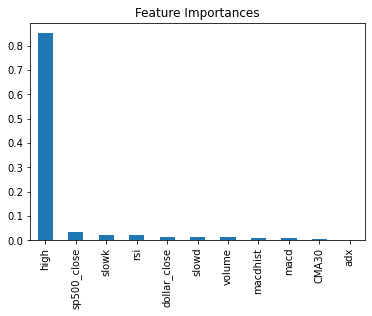

In [60]:
# applies the model
model_fit = gb_mae.fit(X_train_cv, y_train_cv)
# predicts training
y_pred_test = model_fit.predict(X_test_cv)
# evaluate predictions
mae = mean_absolute_error(y_test_cv, y_pred_test)
mse = mean_squared_error(y_test_cv, y_pred_test)
r2 = r2_score(y_test_cv, y_pred_test)

feat_imp = pd.Series(model_fit.feature_importances_, X_train_cv.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [61]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mae','mse'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_mae, gb_mse)

,MAE,MSE,R2
mae,175.266375,75003.458628,0.716209
mse,114.060772,19783.790382,0.925144


In [62]:
gb_200 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 55)
gb_500 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 80)
gb_1500 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 100)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['55','80', '100'])
show_results(df, X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_200, gb_500, gb_1500)

,MAE,MSE,R2
55,97.186424,14361.702609,0.94566
80,106.824322,17629.460462,0.933295
100,111.439669,19081.472546,0.927801


In [63]:
gb_5 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=5)
gb_10 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=10)
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 55,min_samples_split=50)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['5','10', '50'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_5, gb_10,gb_50)

,MAE,MSE,R2
5,98.269546,14700.653448,0.944377
10,98.877467,14940.591887,0.943469
50,101.278893,15927.37606,0.939736


In [64]:
gb_01 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=10, learning_rate=0.05)
gb_005 = GradientBoostingRegressor(random_state = 10 , criterion='squared_error', n_estimators = 55,min_samples_split=10, learning_rate=0.1)
gb_02 = GradientBoostingRegressor(random_state = 10 ,  criterion='squared_error', n_estimators = 55,min_samples_split=10, learning_rate=0.2)
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['0.05','0.1', '0.2'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,gb_005, gb_01, gb_02)

,MAE,MSE,R2
0.05,98.877467,14940.591887,0.943469
0.1,124.757789,21537.396574,0.918509
0.2,146.987284,29873.728398,0.886967


In [65]:
avg_score(gb_005, X, y, 5, 'hmcv', train_period_split=100, test_period_split=5)

('53.424+/-86.48', '12715.911+/-44407.25', '-14.049+/-49.22')

## XGBoost

In [66]:
xgb_mae = XGBRegressor(random_state = 10 , criterion='absolute_error', n_estimators = 130)
xgb_mse = XGBRegressor(random_state = 10 , criterion='squared_error', n_estimators = 130)

<AxesSubplot:title={'center':'Feature Importances'}>

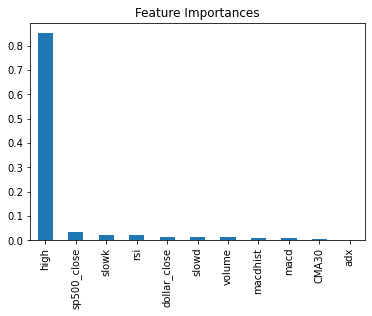

In [67]:
# applies the model
model_fit = gb_mae.fit(X_train_cv, y_train_cv)
# predicts training
y_pred_test = model_fit.predict(X_test_cv)
# evaluate predictions
mae = mean_absolute_error(y_test_cv, y_pred_test)
mse = mean_squared_error(y_test_cv, y_pred_test)
r2 = r2_score(y_test_cv, y_pred_test)

feat_imp = pd.Series(model_fit.feature_importances_, X_train_cv.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [68]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['mae','mse'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,xgb_mae, xgb_mse)

[13:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,MAE,MSE,R2
mae,109.215761,18401.290728,0.930375
mse,109.215761,18401.290728,0.930375


In [69]:
xgb_gbtree = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130)

xgb_gblinear = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130)

xgb_dart = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130)

In [70]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['gbtree','gblinear','dart'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv,xgb_gbtree, xgb_gblinear,xgb_dart )

,MAE,MSE,R2
gbtree,109.215761,18401.290728,0.930375
gblinear,120.612199,20545.40839,0.922262
dart,109.215744,18401.286579,0.930375


In [71]:
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True)

xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False)

In [72]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['True', 'False'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv, xgb_true,xgb_false )

,MAE,MSE,R2
True,129.383468,23200.749822,0.912215
False,100.834672,15304.021361,0.942094


In [73]:
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False)

xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True)

In [74]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['True', 'False'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv, xgb_true,xgb_false )

,MAE,MSE,R2
True,103.435589,15953.003798,0.939639
False,110.269664,17684.797449,0.933086


In [75]:
xgb_005 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.05)

xgb_01 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.1)

xgb_03 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.3)

xgb_05 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False,eta = 0.5)

In [76]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['0,05', '0,1', '0,3', '0,5'])
show_results(df,X_train_cv, X_test_cv, y_train_cv, y_test_cv, xgb_005,xgb_01, xgb_03, xgb_05 )

,MAE,MSE,R2
"0,05",332.926208,160426.379363,0.392995
"0,1",376.226945,189918.312145,0.281406
"0,3",220.880097,64146.470592,0.757289
"0,5",121.537652,20813.549439,0.921248


In [78]:
avg_score(xgb_true, X, y, 5, 'hmcv', train_period_split=100, test_period_split=5)

('56.085+/-71.48', '9269.175+/-27904.91', '-59.136+/-203.21')

# LSTM

In [83]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [159]:
y = scaled_df['close']
X = scaled_df.drop(['close'], axis=1)

In [161]:
X.reset_index(inplace=True)

In [164]:
X.drop('Date', axis=1, inplace=True)

In [165]:
X

,high,volume,CMA30,adx,macd,macdhist,rsi,slowk,slowd,dollar_close,sp500_close
0,-0.354764,-0.703342,-0.546662,0.654631,0.493272,0.108479,1.905817,0.839447,0.454673,-0.273601,-1.020815
1,-0.285521,-0.759625,-0.506423,0.834458,0.646172,0.481387,2.096824,1.577599,1.012913,-0.494745,-1.022653
2,-0.281605,-0.820002,-0.469362,1.005256,0.750345,0.654174,1.998605,1.365336,1.354209,-0.474672,-1.038463
3,-0.324361,-0.911292,-0.435805,1.056771,0.810958,0.680174,1.834188,1.107175,1.450618,-0.324119,-1.003751
4,-0.242806,-0.869161,-0.325981,1.313725,1.004357,0.778813,2.256231,1.166785,1.108845,-0.460955,-0.982823
...,...,...,...,...,...,...,...,...,...,...,...
1094,1.529734,0.067625,2.612355,-1.167335,-0.291331,-1.194162,-0.134580,-0.032460,-0.529192,2.029503,1.601628
1095,1.554782,0.187126,2.618415,-1.231151,-0.302346,-0.983039,-0.225345,0.852291,0.114590,1.846500,1.597603
1096,1.566669,0.636867,2.624197,-1.231543,-0.394967,-1.024394,-0.522911,0.411450,0.435560,1.912408,1.501651
1097,1.453194,0.293238,2.629904,-1.218398,-0.486204,-1.053911,-0.594595,-0.462537,0.280690,2.112808,1.323895


In [114]:
X_train = []

In [170]:
result = pd.read_csv(r'../data/cryptoInd/eth_ind.csv')

In [184]:
result['Date'] = pd.to_datetime(result.Date,format='%Y-%m-%d')
result.index = result['Date']
#plt.figure(figsize=(16,8))
#plt.plot(dataset['Volume'], label='Amount of Stocks')

dataset = result.sort_index(ascending=True, axis=0)
dataset2 = pd.DataFrame(index=range(0,len(dataset)),columns=['Date', 'close'])
for i in range(0,len(dataset)):
    dataset2['Date'][i] = dataset['Date'][i]
    dataset2['close'][i] = dataset['close'][i]
    
dataset2.index = dataset2.Date
dataset2.drop('Date', axis=1, inplace = True)

dataset3 = dataset2.values 

train = dataset3[0:1000, :]
valid = dataset3[1000:, :]
#print(valid)

In [185]:
# puts everything between (0,1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset3)
#print(scaled_data)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))



In [186]:
model = Sequential()
model.add(LSTM( units=1000, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=1000))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

940/940 - 12411s - loss: 0.1216 - 12411s/epoch - 13s/step


In [187]:
len(scaled_data)

1099

In [190]:
X_test = []
for i in range(60,len(valid)):
    X_test.append(scaled_data[i-60:i,0])
X_test = np.array(X_test)
print(len(X_test))

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
#print(X_test.shape)

train = dataset2[:200]
valid = dataset2[200:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10))
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

839


ValueError: Length of values (839) does not match length of index (899)